# 3 Linear Regression - Curve Fitting (TensorFlow)
In this tutorial we will use two methods to fit a curve using [TensorFlow](https://www.tensorflow.org/):
- Direct solution using the least-squares method - this is the same method used in the previous tutorial with NumPy 
- Iterative optimisation using [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent/)

## 3.1 Data
First, as before, we sample $n$ observed data from the underlying polynomial defined by weights $w$:

In [0]:
import random
import numpy as np

# get ground-truth data from the "true" model 
n = 100 
w = [4, 3, 2, 1]
x = np.linspace(-1,1,n)[:,np.newaxis]
t = np.matmul(np.power(np.reshape(x,[-1,1]), 
                       np.linspace(len(w)-1,0,len(w))), w)
std_noise = 0.2
t_observed = np.reshape(
    [t[idx]+random.gauss(0,std_noise) for idx in range(n)],
    [-1,1])

## 3.2 Computation Graph and Session
[Graphs and sessions](https://www.tensorflow.org/guide/graphs) are important features of TensorFlow. Briefly:
1. a **graph** needs to be built to specify what computations are required; the graphs are made up of nodes (mathematical operations) and edges (multidimensional data arrays, i.e. *tensors*, that are consumed or produced by a computation)
1. **sessions** are then constructed to specify what computation to run -  e.g., what data to use and in what order. 

To facilitate the data feeding, [**placeholders**](https://www.tensorflow.org/api_docs/python/tf/placeholder) are used. The following two methods to fit the model provide two examples of how these are used in practice.

First, we build a computation graph using "tf functions":

In [2]:
import tensorflow as tf


# placeholders are used for feeding data in runtime
ph_x = tf.placeholder(tf.float32, [n, 1])
ph_t = tf.placeholder(tf.float32, [n, 1])

deg = 3
# define the computation node X
node_X = tf.pow(ph_x, tf.linspace(tf.to_float(deg),0,deg+1))

Instructions for updating:
Use tf.cast instead.


This above is a very simple computation graph to evaluate the polynomial using TensorFlow functions. This can be built without any real data and there has not been any computation taking place either.  

Then we construct a session. And, call the run method to evaluate the node *node_X* to actually run the computation and obtain the results.

## 3.3 Least-Squares Solution

To begin this curve fitting tutorial, we will start with the same method from the previous NumPy tutorial: the least squares solution. The advantages of using TensorFlow are not obvious with this method, however they will become apparent later for SGD. 

In [3]:
# we complete the computation graph with the least-square solution
node_w = tf.matrix_solve_ls(node_X, ph_t)

# run the session to evaluate the node weights
sess = tf.Session()  
dataFeed = {ph_x:x, ph_t:t_observed}  # feed data
w_lstsq = sess.run(node_w, feed_dict=dataFeed)
print(w_lstsq)
#tf.reset_default_graph()
sess.close()


[[4.042428 ]
 [2.9618015]
 [1.9706464]
 [0.9955562]]


## 3.3 Stochastic Gradient Descend Method
Instead of using least-squares, weights can be optimised by minimising a loss function between the predicted- and observed target values using [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). SGD works by taking the gradient of a random point in our data set and using its value to inform whether to increase or decrease the value of the model weights.

It is not an efficient method for this curve fitting problem; this is only for the purpose of demonstrating how an iterative method can be implemented in TensorFlow.

In [9]:
# build a new graph
ph_1x = tf.placeholder(tf.float32, [1, 1])
ph_1t = tf.placeholder(tf.float32, [1, 1])

deg = 3
node_X = tf.pow(ph_1x, tf.linspace(tf.to_float(deg),0,deg+1))

# first declare variables that need optimisation
var_w = tf.get_variable('weights', shape=[deg+1,1], 
                        initializer=tf.random_normal_initializer(0, 1e-3))

# # complete the computation graph with SGD
# node_1t = tf.matmul(node_X, var_w)
# # define a square loss function
# loss = tf.reduce_mean(tf.square(node_1t-ph_1t))
# # buiding a train-op to minimise the loss
# train_op = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

# # launch a session
# sess = tf.Session()  
# sess.run(tf.global_variables_initializer())  # initialise all the variables

# # iteration to update variables with backprop gradients
# total_iter = int(1e4)
# indices_train = [i for i in range(n)]
# for step in range(total_iter):

#     idx = step % n
#     if idx == 0:  # shuffle every epoch
#         random.shuffle(indices_train)
    
#     # single data point feed
#     singleDataFeed = {
#         ph_1x:x[indices_train[idx],np.newaxis], 
#         ph_1t:t_observed[indices_train[idx],np.newaxis] }
    
#     # print for testing
#     #print(singleDataFeed)
    
#     # update the variables
#     sess.run(train_op, feed_dict=singleDataFeed)
    
#     # print training information
#     if (step % 200) == 0:
#         loss_train = sess.run(loss, feed_dict=singleDataFeed)
#         print('Step %d: Loss=%f' % (step, loss_train))
#     if (step % 2000) == 0:
#         w_sgd = sess.run(var_w)
#         print('Estimated weights:')
#         print(w_sgd)

# w_sgd = sess.run(var_w)
# print('Final weights at step %d:' % step)
# print(w_sgd)
# sess.close()

ValueError: ignored

In [8]:
# complete the computation graph with SGD
node_1t = tf.matmul(node_X, var_w)
# define a square loss function
loss = tf.reduce_mean(tf.square(node_1t-ph_1t))
# buiding a train-op to minimise the loss
train_op = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

# launch a session
sess = tf.Session()  
sess.run(tf.global_variables_initializer())  # initialise all the variables

# iteration to update variables with backprop gradients
total_iter = int(1e4)
indices_train = [i for i in range(n)]
for step in range(total_iter):

    idx = step % n
    if idx == 0:  # shuffle every epoch
        random.shuffle(indices_train)
    
    # single data point feed
    singleDataFeed = {
        ph_1x:x[indices_train[idx],np.newaxis], 
        ph_1t:t_observed[indices_train[idx],np.newaxis] }
    
    # print for testing
    #print(singleDataFeed)
    
    # update the variables
    sess.run(train_op, feed_dict=singleDataFeed)
    
    # print training information
    if (step % 200) == 0:
        loss_train = sess.run(loss, feed_dict=singleDataFeed)
        print('Step %d: Loss=%f' % (step, loss_train))
    if (step % 2000) == 0:
        w_sgd = sess.run(var_w)
        print('Estimated weights:')
        print(w_sgd)

w_sgd = sess.run(var_w)
print('Final weights at step %d:' % step)
print(w_sgd)
sess.close()

Step 0: Loss=12.568729
Estimated weights:
[[0.59463495]
 [0.76435673]
 [0.98188186]
 [1.2611164 ]]
Step 200: Loss=0.020210
Step 400: Loss=0.075130
Step 600: Loss=0.003327
Step 800: Loss=0.023082
Step 1000: Loss=0.054252
Step 1200: Loss=0.013319
Step 1400: Loss=0.043618
Step 1600: Loss=0.018131
Step 1800: Loss=0.084470
Step 2000: Loss=0.001207
Estimated weights:
[[4.0472703]
 [2.9199054]
 [1.9787805]
 [1.0194025]]
Step 2200: Loss=0.002373
Step 2400: Loss=0.088748
Step 2600: Loss=0.002565
Step 2800: Loss=0.000068
Step 3000: Loss=0.006142
Step 3200: Loss=0.003426
Step 3400: Loss=0.001752
Step 3600: Loss=0.016715
Step 3800: Loss=0.013774
Step 4000: Loss=0.000079
Estimated weights:
[[3.9630163 ]
 [2.9695551 ]
 [1.9255192 ]
 [0.98675376]]
Step 4200: Loss=0.000119
Step 4400: Loss=0.002625
Step 4600: Loss=0.000093
Step 4800: Loss=0.006856
Step 5000: Loss=0.038958
Step 5200: Loss=0.064046
Step 5400: Loss=0.001451
Step 5600: Loss=0.000171
Step 5800: Loss=0.015023
Step 6000: Loss=0.011663
Estimat

# Playing around with the optimiser



In [29]:
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import numpy as np
from IPython import display

# get ground-truth data from the "true" model 
n = 100 
w = [4, 3, 2, 1]
x = np.linspace(-1,1,n)[:,np.newaxis]
t = np.matmul(np.power(np.reshape(x,[-1,1]), 
                       np.linspace(len(w)-1,0,len(w))), w)
std_noise = 0.2
t_observed = np.reshape(
    [t[idx]+random.gauss(0,std_noise) for idx in range(n)],
    [-1,1])

loss_val = np.array([])

# build a new graph
ph_1x = tf.placeholder(tf.float32, [1, 1])
ph_1t = tf.placeholder(tf.float32, [1, 1])

deg = 3
node_X = tf.pow(ph_1x, tf.linspace(tf.to_float(deg),0,deg+1))

# first declare variables that need optimisation
var_w = tf.get_variable('weights', shape=[deg+1,1], 
                        initializer=tf.random_normal_initializer(0, 1e-3))



ValueError: ignored

In [35]:
# complete the computation graph with SGD
node_1t = tf.matmul(node_X, var_w)
# define a square loss function
loss = tf.reduce_mean(tf.square(node_1t-ph_1t))
# buiding a train-op to minimise the loss
train_op = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)

# launch a session
sess = tf.Session()  
sess.run(tf.global_variables_initializer())  # initialise all the variables

# iteration to update variables with backprop gradients
total_iter = int(1e4)
indices_train = [i for i in range(n)]
for step in range(total_iter):
    
    idx = step % n
    if idx == 0:  # shuffle every epoch
        random.shuffle(indices_train)
    
    # single data point feed
    singleDataFeed = {
        ph_1x:x[indices_train[idx],np.newaxis], 
        ph_1t:t_observed[indices_train[idx],np.newaxis] }
    
    
    # update the variables
    sess.run(train_op, feed_dict=singleDataFeed)
    
    if (step % 1) == 0:
        loss_train = sess.run(loss, feed_dict=singleDataFeed)
        loss_val = np.append(loss_val,loss_train)
#         print(loss_train,loss_val)
#         display.clear_output()
#         plt.plot(loss_val)
#         plt.show()
#         plt.draw()
    
    # print training information
    if (step % 200) == 0:
        loss_train = sess.run(loss, feed_dict=singleDataFeed)
        print('Step %d: Loss=%f' % (step, loss_train))
    if (step % 2000) == 0:
        w_sgd = sess.run(var_w)
        print('Estimated weights:')
        print(w_sgd)

w_sgd = sess.run(var_w)
print('Final weights at step %d:' % step)
print(w_sgd)
sess.close()

Step 0: Loss=0.000524
Estimated weights:
[[-0.00015834]
 [ 0.0016035 ]
 [-0.00189796]
 [ 0.00579561]]
Step 200: Loss=0.002952
Step 400: Loss=0.017667
Step 600: Loss=0.005801
Step 800: Loss=0.105830
Step 1000: Loss=0.004777
Step 1200: Loss=0.004457
Step 1400: Loss=0.000233
Step 1600: Loss=0.000001
Step 1800: Loss=0.033103
Step 2000: Loss=0.004255
Estimated weights:
[[3.9869955]
 [3.0759559]
 [2.0708253]
 [1.0543575]]
Step 2200: Loss=0.088015
Step 2400: Loss=0.000956
Step 2600: Loss=0.000161
Step 2800: Loss=0.006362
Step 3000: Loss=0.007608
Step 3200: Loss=0.005370
Step 3400: Loss=0.019030
Step 3600: Loss=0.047488
Step 3800: Loss=0.080505
Step 4000: Loss=0.013774
Estimated weights:
[[3.9725544]
 [2.9878843]
 [2.0620942]
 [0.9932699]]
Step 4200: Loss=0.000793
Step 4400: Loss=0.031846
Step 4600: Loss=0.021458
Step 4800: Loss=0.001150
Step 5000: Loss=0.003445
Step 5200: Loss=0.000197
Step 5400: Loss=0.009190
Step 5600: Loss=0.002325
Step 5800: Loss=0.029196
Step 6000: Loss=0.000763
Estimate

array([3.00540179e-01, 1.60094583e+00, 1.59197852e-01, ...,
       1.72654241e-02, 4.12546331e-04, 3.36744054e-03])

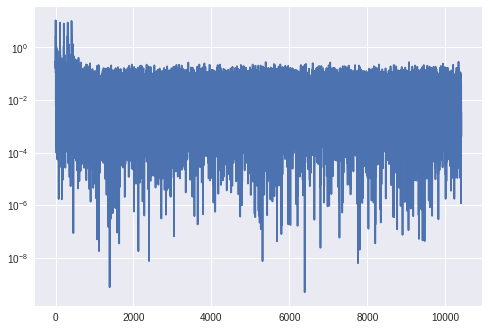

In [37]:
plt.plot(loss_val)
plt.yscale('log')
loss_val

# Playing around with more than one point at a time

In [4]:
import numpy as np
import tensorflow as tf
import random

# get ground-truth data from the "true" model 
n = 100 
w = [4, 3, 2, 1]
x = np.linspace(-1,1,n)[:,np.newaxis]
t = np.matmul(np.power(np.reshape(x,[-1,1]), 
                       np.linspace(len(w)-1,0,len(w))), w)
std_noise = 0.2
t_observed = np.reshape(
    [t[idx]+random.gauss(0,std_noise) for idx in range(n)],
    [-1,1])

loss_val = np.array([])

# build a new graph
ph_nx = tf.placeholder(tf.float32, [n, 1])
ph_nt = tf.placeholder(tf.float32, [n, 1])

deg = 3
node_nX = tf.pow(ph_nx, tf.linspace(tf.to_float(deg),0,deg+1))

# first declare variables that need optimisation
var_w_n = tf.get_variable('weights', shape=[deg+1,1], 
                        initializer=tf.random_normal_initializer(0, 1e-3))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.


In [17]:
# complete the computation graph with SGD
node_nt = tf.matmul(node_nX, var_w_n)
# define a square loss function
loss = tf.reduce_mean(tf.square(node_nt-ph_nt))
# buiding a train-op to minimise the loss
train_op = tf.train.GradientDescentOptimizer(learning_rate=1e-1).minimize(loss)


# launch a session
sess = tf.Session()  
sess.run(tf.global_variables_initializer())  # initialise all the variables

# iteration to update variables with backprop gradients
total_iter = int(1e4)
indices_train = [i for i in range(n)]
for step in range(total_iter):
    
    idx = step % n
    if idx == 0:  # shuffle every epoch
        random.shuffle(indices_train)
    
    # single data point feed
    nDataFeed = {
        ph_nx:x[indices_train], 
        ph_nt:t_observed[indices_train] }
    
    
    # update the variables
    sess.run(train_op, feed_dict=nDataFeed)
    
    if (step % 1) == 0:
        loss_train = sess.run(loss, feed_dict=nDataFeed)
        loss_val = np.append(loss_val,loss_train)
#         print(loss_train,loss_val)
#         display.clear_output()
#         plt.plot(loss_val)
#         plt.show()
#         plt.draw()
    
    # print training information
    if (step % 200) == 0:
        loss_train = sess.run(loss, feed_dict=nDataFeed)
        print('Step %d: Loss=%f' % (step, loss_train))
    if (step % 2000) == 0:
        w_sgd = sess.run(var_w_n)
        print('Estimated weights:')
        print(w_sgd)

w_sgd = sess.run(var_w_n)
print('Final weights at step %d:' % step)
print(w_sgd)
sess.close()

Step 0: Loss=8.957877
Estimated weights:
[[0.20210573]
 [0.19630885]
 [0.29808432]
 [0.41059282]]
Step 200: Loss=0.076045
Step 400: Loss=0.057459
Step 600: Loss=0.053000
Step 800: Loss=0.051892
Step 1000: Loss=0.051618
Step 1200: Loss=0.051549
Step 1400: Loss=0.051532
Step 1600: Loss=0.051528
Step 1800: Loss=0.051527
Step 2000: Loss=0.051527
Estimated weights:
[[4.043354 ]
 [2.9940155]
 [1.917656 ]
 [1.0286484]]
Step 2200: Loss=0.051527
Step 2400: Loss=0.051527
Step 2600: Loss=0.051527
Step 2800: Loss=0.051527
Step 3000: Loss=0.051527
Step 3200: Loss=0.051527
Step 3400: Loss=0.051527
Step 3600: Loss=0.051527
Step 3800: Loss=0.051527
Step 4000: Loss=0.051527
Estimated weights:
[[4.045168 ]
 [2.9940155]
 [1.9164847]
 [1.0286484]]
Step 4200: Loss=0.051527
Step 4400: Loss=0.051527
Step 4600: Loss=0.051527
Step 4800: Loss=0.051527
Step 5000: Loss=0.051527
Step 5200: Loss=0.051527
Step 5400: Loss=0.051527
Step 5600: Loss=0.051527
Step 5800: Loss=0.051527
Step 6000: Loss=0.051527
Estimated we

array([8.96591282, 8.96162033, 8.95787716, 6.84207344, 5.34344864,
       4.25572634, 3.44780445, 2.8350184 , 2.36165905, 1.99028122,
       1.69512713, 1.4580456 , 1.26593745, 1.10913396, 0.98035133,
       0.87400317, 0.78574198, 0.71214247, 0.65047973, 0.59856939,
       0.55465031, 0.51729625, 0.48534772, 0.45786023, 0.4340623 ,
       0.41332304, 0.39512566, 0.37904626, 0.36473691, 0.35191199,
       0.34033638, 0.3298164 , 0.32019246, 0.31133288, 0.30312881,
       0.29549024, 0.28834236, 0.28162313, 0.27528092, 0.26927242,
       0.26356152, 0.25811774, 0.25291553, 0.247933  , 0.24315184,
       0.23855606, 0.23413204, 0.22986801, 0.22575372, 0.22178009,
       0.21793924, 0.21422401, 0.21062812, 0.20714588, 0.20377208,
       0.20050205, 0.19733131, 0.19425602, 0.19127233, 0.18837683,
       0.18556617, 0.18283735, 0.18018752, 0.17761385, 0.17511368,
       0.17268459, 0.17032419, 0.1680302 , 0.16580045, 0.1636328 ,
       0.16152526, 0.15947588, 0.15748288, 0.15554437, 0.15365

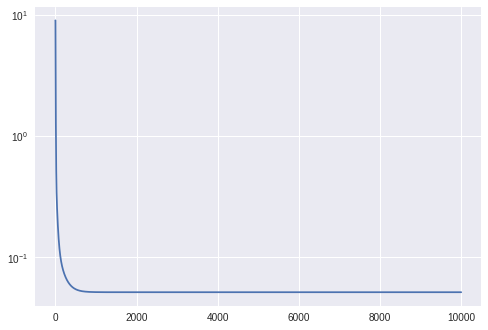

In [29]:
import matplotlib.pyplot as plt

plt.plot(loss_val[::])
plt.yscale('log')
loss_val[:100:]

## Questions
- What happens to the convergence when you try other optimisation hyperparameters, such as a different optimiser, learning rate and number of iterations? You could try plotting the loss as a function of step for each hypermarater. 
- Try adding regularisers and different loss functions. How does this affect the performance?
- Would batch gradient descent or minibatch gradient descent improve the optimisation?
- Would higher-degree models be more prone to overfitting and why?
